In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import os
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt

In [2]:
columns = ['center','left','right','steering','throttle','reverse', 'speed']
data = pd.read_csv('./driving_log.csv', names = columns, sep=';')

In [3]:
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

define the dataset

In [4]:
class ImageDataset(Dataset):   
    def __init__(self, csv_file, root_dir, transform=None):
        columns = ['center','left','right','steering','throttle','reverse', 'speed']
        self.annotations = pd.read_csv('./driving_log.csv', sep=';', names = columns)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = self.root_dir + self.annotations.iloc[idx, 0]
        image = io.imread(img_name)
        if self.transform:
            image = self.transform(image)
            
        return image

images are 320 x 160

Let's define the model

In [5]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(8*32*32, 100)
        )
        self.bridge = nn.Sequential(nn.Linear(100, 8*32*32))
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 
                               kernel_size=3, 
                               stride=2, 
                               padding=1, 
                               output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 
                               kernel_size=3, 
                               stride=2, 
                               padding=1, 
                               output_padding=1),
            nn.Sigmoid()
        )
         
    def forward(self, x):
        x = self.encoder(x)
        x = self.bridge(x)
        x = x.reshape(x.shape[0], -1, 32, 32)
        x = self.decoder(x)
        return x


In [6]:
model = Autoencoder()

Now let's define the image preprocessing

In [7]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128, 128)),
])

In [8]:
street_dataset = ImageDataset('./driving_log.csv', '.', transform=img_transform)

In [9]:
for i, img in enumerate(street_dataset):
    print(i, img.size())

    if i == 3:
        break

0 torch.Size([3, 128, 128])
1 torch.Size([3, 128, 128])
2 torch.Size([3, 128, 128])
3 torch.Size([3, 128, 128])


In [10]:
train_loader = DataLoader(dataset=street_dataset, batch_size=128)

Prepare for training

In [11]:
print(device)
model.to(device)

cpu


Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=8192, out_features=100, bias=True)
  )
  (bridge): Sequential(
    (0): Linear(in_features=100, out_features=8192, bias=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(16, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): Sigmoid()
  )
)

In [12]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
num_epochs = 50
for epoch in range(num_epochs):
    for img in train_loader:
        img = img.to(device)
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()
    if epoch % 5== 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

Epoch [1/50], Loss: 0.0270
Epoch [6/50], Loss: 0.0222
Epoch [11/50], Loss: 0.0182
Epoch [16/50], Loss: 0.0154
Epoch [21/50], Loss: 0.0131
Epoch [26/50], Loss: 0.0121
Epoch [31/50], Loss: 0.0109
Epoch [36/50], Loss: 0.0100
Epoch [41/50], Loss: 0.0098
Epoch [46/50], Loss: 0.0090


In [14]:
torch.save(model.state_dict(), 'Autoencoder.pth')
torch.save(model, './autoencoder.pt')

In [15]:
data.iloc[-2]['center']

'/IMG/center_2020_07_14_14_33_42_917.jpg'

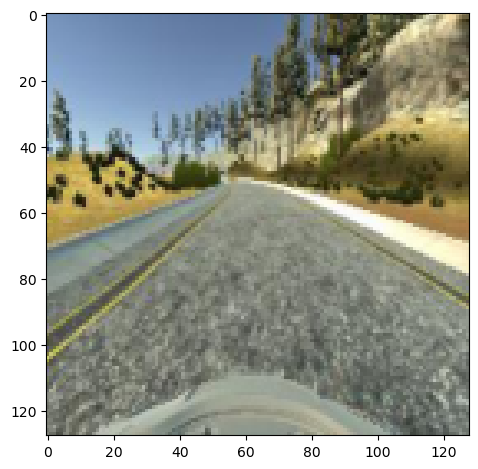

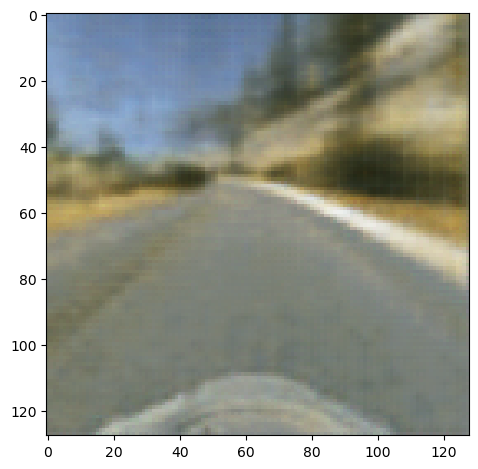

torch.Size([1, 100])


In [16]:
with torch.no_grad():
    for i in range(1):
        image = io.imread( "./" + data.iloc[-(i+1)]['center'])
        image = img_transform(image)
        io.imshow(image.cpu().numpy().transpose((1,2,0)))
        plt.show()
        image = image.to(device)
        image = image.unsqueeze(0)
        reconstruct = model(image)
        reconstruct = reconstruct.squeeze()
        io.imshow(reconstruct.cpu().numpy().transpose((1,2,0)))
        plt.show()
        latent = model.encoder(image)
        print(latent.size())

In [17]:
torch.load

<function torch.serialization.load(f: Union[str, os.PathLike, BinaryIO, IO[bytes]], map_location: Union[Callable[[torch.types.Storage, str], torch.types.Storage], torch.device, str, Dict[str, str], NoneType] = None, pickle_module: Any = None, *, weights_only: Optional[bool] = None, mmap: Optional[bool] = None, **pickle_load_args: Any) -> Any>

In [18]:
model.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=8192, out_features=100, bias=True)
  )
  (bridge): Sequential(
    (0): Linear(in_features=100, out_features=8192, bias=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(16, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): Sigmoid()
  )
)

In [29]:
encodings = []
counter = 0
with torch.no_grad():
    for idx in range(len(street_dataset)):
        img = street_dataset[idx]
        img.unsqueeze(0)
        img = image.to(device)
        representation = model.encoder(img)
        representation = representation.transpose(0,1).detach().cpu().numpy()
        encodings.append(representation)
        counter = counter + 1

In [41]:
enc_sq = []
for e in encodings:
    enc_sq.append(e.squeeze().tolist())

In [43]:
tst = pd.DataFrame(enc_sq)

In [44]:
tst.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,3.177433,-3.216654,-0.612901,0.572941,1.233803,-3.416058,3.342008,1.40979,1.495512,-1.48627,...,-0.980103,0.139733,0.615371,-1.683151,-2.447335,2.923427,2.054011,-0.785271,0.445538,-1.963845
1,3.177433,-3.216654,-0.612901,0.572941,1.233803,-3.416058,3.342008,1.40979,1.495512,-1.48627,...,-0.980103,0.139733,0.615371,-1.683151,-2.447335,2.923427,2.054011,-0.785271,0.445538,-1.963845
2,3.177433,-3.216654,-0.612901,0.572941,1.233803,-3.416058,3.342008,1.40979,1.495512,-1.48627,...,-0.980103,0.139733,0.615371,-1.683151,-2.447335,2.923427,2.054011,-0.785271,0.445538,-1.963845
3,3.177433,-3.216654,-0.612901,0.572941,1.233803,-3.416058,3.342008,1.40979,1.495512,-1.48627,...,-0.980103,0.139733,0.615371,-1.683151,-2.447335,2.923427,2.054011,-0.785271,0.445538,-1.963845
4,3.177433,-3.216654,-0.612901,0.572941,1.233803,-3.416058,3.342008,1.40979,1.495512,-1.48627,...,-0.980103,0.139733,0.615371,-1.683151,-2.447335,2.923427,2.054011,-0.785271,0.445538,-1.963845


In [ ]:
tst..to_csv("./driving_log_train.", sep=';', index=False, header=False)